# Predicting product cancelations for sales retention
Investigate machine learning techniques to predict the likely-hood of a product cancellation based on existing sales and amount spent in annual maintenance. To enable the targeting of retention resources and offers to those customers who are predicted as at risk. 

# libaries, functions and pipeline

In [2]:
# get updated version on pandas
import pandas as pd
from distutils.version import LooseVersion, StrictVersion
if LooseVersion(pd.__version__) < LooseVersion("0.22.0"):
    !pip install --upgrade pandas
    pd.__version__
    print("pandas version was: " + pd.__version__ + " It has been updated, please restart the kernel")
else:
    print("pandas version is high enough")

pandas version is high enough


In [3]:
#some extra libs that we need in the page:
!pip install pdtransform
!pip install tabulate
!pip install seaborn==0.9.0 

In [31]:
# setup the notebook and import libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats, integrate
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import (
    auc,
    confusion_matrix,
    precision_recall_curve,
    precision_score,
    recall_score,
    roc_curve,
    accuracy_score
    )
from tabulate import tabulate
from sklearn.dummy import DummyClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score,recall_score,confusion_matrix, classification_report,make_scorer
from sklearn.preprocessing import StandardScaler,RobustScaler,Normalizer,QuantileTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import decomposition
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
#from sklearn import cross_validation
from pdtransform import DFTransform, DFFeatureUnion
from sklearn.model_selection import GridSearchCV
from scipy.stats import uniform
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
%matplotlib inline

#Get the data from the same folder as the notebook and test the pandas version
csvData = './ResultsGrid.csv'
isCancelledKey = 'isCancelled'
customerIdKey = 'customerId'
adminAreaKey = 'administrativeArea'
subCountryKey = 'subCountryArea'
countryKey = 'country'
avgDaysToPay='avgDaysToPay'

In [29]:
#seaborn defaults - see http://www.jesshamrick.com/2016/04/13/reproducible-plots/
sns.set_context("paper") 
# Set the font to be serif, rather than sans
sns.set(font='serif')
# Make the background white, and specify the
# specific font family
sns.set_style("white", {
    "font.family": "serif",
    "font.serif": ["Times", "Palatino", "serif"]
})
# configure seaborn https://seaborn.pydata.org/
sns.set(color_codes=True)
colors = ["amber", "windows blue", "red","green", "grey", "dusty purple"]
sns.set_palette(sns.xkcd_palette(colors))

In [8]:
#load the dataframe in
dataFrame = pd.read_csv(csvData)
isCancelledIndex = dataFrame.columns.get_loc(isCancelledKey)
dataFrame = dataFrame.infer_objects()
nans = lambda df: df[df.isnull().any(axis=1)]
nans(dataFrame)

,customerId,amountTotal,salesTotal,annualTotal,monthlyTotalProduct1,monthlyTotalProduct2,extraItemsTotal,monthsSinceStarted,avgDaysToPay,creditedAmount,...,hasProduct7,hasProduct8,hasProduct9,hasProduct10,hasProduct11,hasProduct12,administrativeArea,subCountryArea,country,firstInvoiceDate


# Functions

In [9]:
def getTrainTestSplit(df):
    #remove the dependant variable and columns that have no value in training
    data = df.drop([isCancelledKey], axis=1)
    # Set monthsSinceStarted and avgDaysToPay to 0 if negative
    df.loc[:, ['monthsSinceStarted','avgDaysToPay']]  = df[['monthsSinceStarted','avgDaysToPay']].clip(lower=0)
    X_train, X_test, y_train, y_test = train_test_split( data, df[isCancelledKey], test_size=0.33, random_state=42, stratify=df[isCancelledKey])
    
    print('y_train class distribution')
    print(y_train.value_counts(normalize=True))
    print('y_test class distribution')
    print(y_test.value_counts(normalize=True))
    
    return X_train, X_test, y_train, y_test

In [10]:
def printConfusionMatrix(confusion_matrix, printName = "", figsize = (10,7), fontsize=14):
    classNames = ['false', 'true']
    df_cm = pd.DataFrame(
        confusion_matrix, index=classNames, columns=classNames, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
    if(printName != ""):
        confusionMatrixfig = heatmap.get_figure()
        confusionMatrixfig.savefig(printName, format='eps')
    
    return fig

In [11]:
def printDescribe(afterString, df):
    print(f"{afterString} - Number of features {len(df.columns)}")

In [12]:
def getOneHotEncodeData(df):
    categoryFeatures = [subCountryKey] #[adminAreaKey, subCountryKey,countryKey]
    oneHotDataframe = pd.get_dummies(df,columns=categoryFeatures, dummy_na=True)
    return oneHotDataframe

In [13]:
def printClassificationReport(y_test, y_pred, asLatex = False):
    clfReport = classification_report(y_test, y_pred)
    print(clfReport)

In [14]:
def GridSearchCVOnPipeline(X, y, pipeline, param_grid, refitScore):
    skf = StratifiedKFold(n_splits=3)
    scorers = {
        'precision_score': make_scorer(precision_score),
        'recall_score': make_scorer(recall_score),
        'accuracy_score': make_scorer(accuracy_score)
    }
    
    grid = GridSearchCV(
        pipeline, 
        cv=skf,  
        param_grid=param_grid,
        scoring=scorers, 
        refit=refitScore,
        return_train_score=True, 
        n_jobs=-1
    )
    bestModel = grid.fit(X, y)
    #mean_scores = np.array(grid.cv_results_['mean_test_score'])
    #print(mean_scores)
    print(f"Number of features {len(X.columns)}")
    return bestModel
    
def BestModelScore(X_test, y_test, grid, refitScore, printName=""):
    y_pred = grid.predict(X_test.values)

    print('Best params for {}'.format(refitScore))
    print(grid.best_params_)

    print('\nConfusion matrix for {} on the test data:'.format(refitScore))
    print(pd.DataFrame(
            confusion_matrix(y_test, y_pred),
            columns=['pred_neg', 'pred_pos'], 
            index=['neg', 'pos'])
         )
    printConfusionMatrix(confusion_matrix(y_test,y_pred), printName)
    printClassificationReport(y_test, y_pred)
    
    #return grid

In [22]:
def RemoveSkew(df):
    skewColumns = df.skew(numeric_only="true")
    skewRightColumns = skewColumns[lambda x : (x > 0.25)]
    #note ignoring 'int64' gives better results - why?
    skewRightDf = df[skewRightColumns.index].select_dtypes(include=['float64'])
    # 1+ to get rid of -inf value
    df[skewRightDf.columns] = np.log(1+skewRightDf)
    #skewLeftColumns = skewColumns[lambda x : (x < -3.0)]
    return df

In [16]:
def RemoveLeftSkew(df):
    skewColumns = df.skew(numeric_only="true")
    skewLeftColumns = skewColumns[lambda x : (x < -0.25)]
    skewLeftDf = df[skewLeftColumns.index].select_dtypes(include=['float64'])
    # 1+ to get rid of -inf value
    df[skewLeftDf.columns] = np.log(1+skewLeftDf)
    return df

# Sklearn pipeline

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64
Number of features 21
Best params for precision_score
{'classifier__C': 1.4347788054641235, 'classifier__penalty': 'l1'}

Confusion matrix for precision_score on the test data:
     pred_neg  pred_pos
neg       665       194
pos       162       523


C:\Users\nathan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


             precision    recall  f1-score   support

      False       0.80      0.77      0.79       859
       True       0.73      0.76      0.75       685

avg / total       0.77      0.77      0.77      1544



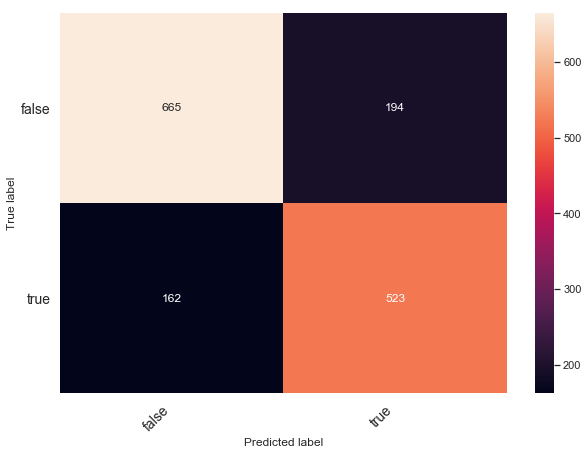

In [17]:
X_train, X_test, y_train, y_test = getTrainTestSplit(dataFrame)
C = uniform(loc=0, scale=4).rvs(10)
refitScore = 'precision_score'
param_grid = [
    {
        'classifier__C': C,
        'classifier__penalty':['l1', 'l2']
    }
]

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
])
clfPipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('classifier', LogisticRegression())
])

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore, "initialScore.eps")

## One hot encode the dataframe before the pipeline

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64
Number of features 37
Best params for precision_score
{'classifier__C': 3.58212724143124, 'classifier__penalty': 'l2'}

Confusion matrix for precision_score on the test data:
     pred_neg  pred_pos
neg       676       183
pos       163       522
             precision    recall  f1-score   support

      False       0.81      0.79      0.80       859
       True       0.74      0.76      0.75       685

avg / total       0.78      0.78      0.78      1544



C:\Users\nathan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


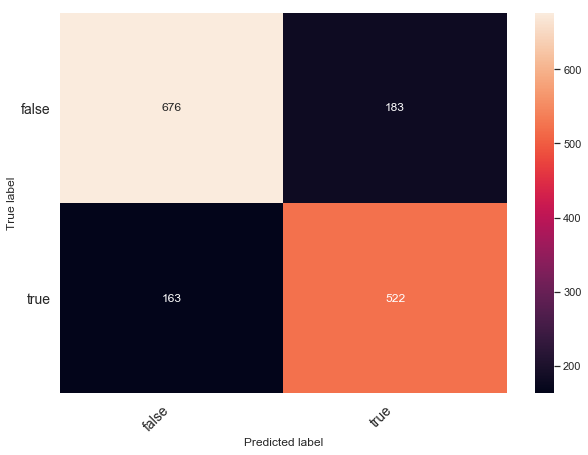

In [19]:
oneHotDataFrame = getOneHotEncodeData(dataFrame)
X_train, X_test, y_train, y_test = getTrainTestSplit(oneHotDataFrame)
C = uniform(loc=0, scale=4).rvs(10)
refitScore = 'precision_score'
param_grid = [
    {
        'classifier__C': C,
        'classifier__penalty':['l1', 'l2']
    }
]

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
])
clfPipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('classifier', LogisticRegression())
])

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore)

## Remove Skew on amount columns

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64
Number of features 37
Best params for precision_score
{'classifier__C': 1.6877276410267883, 'classifier__penalty': 'l2'}

Confusion matrix for precision_score on the test data:
     pred_neg  pred_pos
neg       715       144
pos       176       509
             precision    recall  f1-score   support

      False       0.80      0.83      0.82       859
       True       0.78      0.74      0.76       685

avg / total       0.79      0.79      0.79      1544



C:\Users\nathan\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


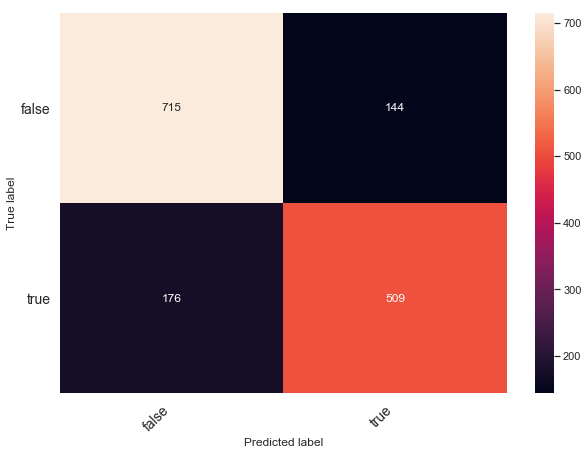

In [23]:
oneHotDataFrame = getOneHotEncodeData(dataFrame)
X_train, X_test, y_train, y_test = getTrainTestSplit(oneHotDataFrame)
C = uniform(loc=0, scale=4).rvs(10)
refitScore = 'precision_score'
param_grid = [
    {
        'classifier__C': C,
        'classifier__penalty':['l1', 'l2']
    }
]

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('Remove skew value cols',DFTransform(RemoveSkew))
])
clfPipeline = Pipeline([
    ('scaler',StandardScaler()),
    ('classifier', LogisticRegression())
])

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore)

## PCA

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64
Number of features 37
Best params for precision_score
{'classifier__C': 3.3821016284384915, 'classifier__penalty': 'l2', 'reduceDimensions__n_components': None, 'reduceDimensions__whiten': False}

Confusion matrix for precision_score on the test data:
     pred_neg  pred_pos
neg       717       142
pos       175       510
             precision    recall  f1-score   support

      False       0.80      0.83      0.82       859
       True       0.78      0.74      0.76       685

avg / total       0.79      0.79      0.79      1544



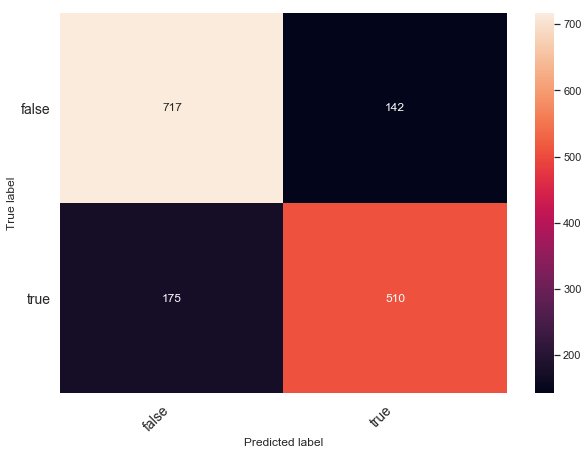

In [24]:
oneHotDataFrame = getOneHotEncodeData(dataFrame)
X_train, X_test, y_train, y_test = getTrainTestSplit(oneHotDataFrame)
C = uniform(loc=0, scale=4).rvs(10)
refitScore = 'precision_score'
pca = decomposition.PCA(n_components=0.5, whiten=False)
param_grid = [
    {
        'reduceDimensions__n_components': (0.5,0.6, 0.7, 0.8,0.9,None),
        'reduceDimensions__whiten':(True,False),
        'classifier__C': C,
        'classifier__penalty':['l1', 'l2']
    }
]

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('Remove skew value cols',DFTransform(RemoveSkew))
])
clfPipeline = Pipeline([
    ('scaler',RobustScaler()),
    ('reduceDimensions', pca),
    ('classifier', LogisticRegression())
])

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore)

# Test classifiers - THIS IS SLOW!
The output is:
```
{'classifier__activation': 'tanh', 'classifier__alpha': 1e-06, 'classifier__hidden_layer_sizes': 5, 'classifier__max_iter': 500, 'classifier__random_state': 3, 'classifier__solver': 'lbfgs'}
```

In [ ]:
#Only run this if you want to max out your CPU!
oneHotDataFrame = getOneHotEncodeData(dataFrame)
X_train, X_test, y_train, y_test = getTrainTestSplit(oneHotDataFrame)
C = uniform(loc=0, scale=4).rvs(10)
refitScore = 'precision_score'
#pca = decomposition.PCA(n_components= None, whiten= True)
n_features_to_test = np.arange(1, 11)
reduceFeatures = (2,4, 6, 8,10,12,14,16,18,20,22,24,26,28,30)
percentageFeatures = (0.5,0.6, 0.7, 0.8,0.9,None)
alpha_to_test = 2.0**np.arange(-6, +6)
lrPenatlies = ['l1', 'l2']
scalersToTest = [StandardScaler(), RobustScaler(), QuantileTransformer()]
classifiersToTest = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=30),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]

param_grid = [
    #'classifier__n_estimators': [10, 100, 1000], 
    #'classifier__max_features': [5, 10, 20],
    #{
        #'classifier':classifiersToTest,
        #'scaler': scalersToTest,
        #'reduceDimensions': [PCA()],
        #'reduceDimensions__n_components': percentageFeatures,
        #'reduceDimensions__whiten':(True,False)
    #},
    #{
        #'classifier':classifiersToTest,
        #'scaler': scalersToTest,
        #'reduceDimensions': [SelectKBest(f_classif)], # ANOVA (f_classif) scoring
        #'reduceDimensions__k': reduceFeatures
    #}
    {
        'classifier__activation': ["identity", "logistic", "tanh", "relu"],
        'classifier__solver': ['lbfgs'], 
        'classifier__max_iter': [500,1000,1500], 
        'classifier__alpha': 10.0 ** -np.arange(1, 7), 
        'classifier__hidden_layer_sizes':np.arange(5, 12), 
        'classifier__random_state':[0,1,2,3,4,5,6,7,8,9]
    }
]

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('Remove skew value cols',DFTransform(RemoveSkew)),
])
clfPipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('reduceDimensions', pca()),
    #('feature_selection', SelectFromModel(LinearSVC(penalty="l1"))),
    #('classifier', RandomForestClassifier(n_estimators=1000))
    ('classifier', MLPClassifier(alpha=1))
])
#MLPClassifier(alpha=1)

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore)

# Using MLPClassifier for a NN, after some hyper parameter work (not slow)

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64
Number of features 21
Best params for precision_score
{'classifier__activation': 'tanh', 'classifier__alpha': 1e-06, 'classifier__hidden_layer_sizes': 11, 'classifier__max_iter': 100, 'classifier__random_state': 3, 'classifier__solver': 'lbfgs'}

Confusion matrix for precision_score on the test data:
     pred_neg  pred_pos
neg       760        99
pos       184       501
             precision    recall  f1-score   support

      False       0.81      0.88      0.84       859
       True       0.83      0.73      0.78       685

avg / total       0.82      0.82      0.81      1544



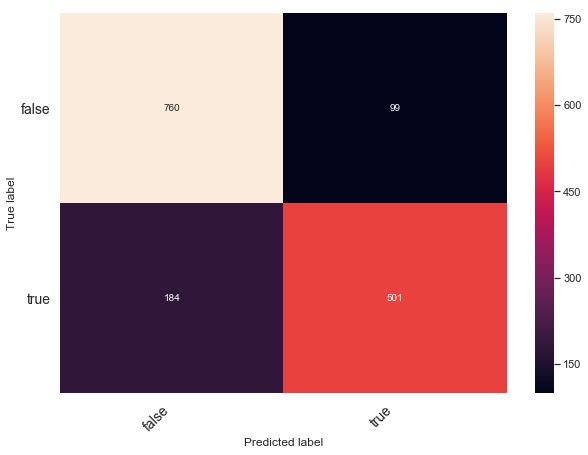

In [32]:
# after running the above overnight we get:
#{'classifier__activation': 'tanh', 'classifier__alpha': 1e-06, 'classifier__hidden_layer_sizes': 5, 'classifier__max_iter': 500, 'classifier__random_state': 3, 'classifier__solver': 'lbfgs'}

X_train, X_test, y_train, y_test = getTrainTestSplit(dataFrame)
refitScore = 'precision_score'

param_grid = [
    {
        'classifier__activation': ["tanh"],
        'classifier__solver': ['lbfgs'], 
        'classifier__max_iter': [100,200,300,400,500], #200 giving a better score
        'classifier__alpha': [1e-06], 
        'classifier__hidden_layer_sizes':[11], # changed from 5 after manual intervention
        'classifier__random_state':[3]
    }
]

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('Remove skew value cols',DFTransform(RemoveSkew)),
])
clfPipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('reduceDimensions', PCA()),
    ('classifier', MLPClassifier(alpha=1e-06))
])

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore)

# Currently working on this section
# Trying to improve the true -> false score

y_train class distribution
False    0.555875
True     0.444125
Name: isCancelled, dtype: float64
y_test class distribution
False    0.556347
True     0.443653
Name: isCancelled, dtype: float64
Number of features 21
Best params for precision_score
{'classifier__activation': 'tanh', 'classifier__alpha': 1e-06, 'classifier__hidden_layer_sizes': 11, 'classifier__max_iter': 100, 'classifier__random_state': 3, 'classifier__solver': 'lbfgs'}

Confusion matrix for precision_score on the test data:
     pred_neg  pred_pos
neg       760        99
pos       184       501
             precision    recall  f1-score   support

      False       0.81      0.88      0.84       859
       True       0.83      0.73      0.78       685

avg / total       0.82      0.82      0.81      1544



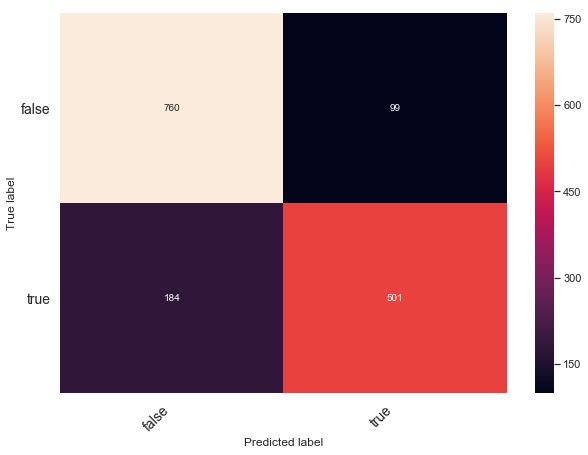

In [34]:
X_train, X_test, y_train, y_test = getTrainTestSplit(dataFrame)
refitScore = 'precision_score'

param_grid = [
    {
        'classifier__activation': ["tanh"],
        'classifier__solver': ['lbfgs'], 
        'classifier__max_iter': [100], #after manual tweaking with the hidden layer size
        'classifier__alpha': [1e-06], 
        'classifier__hidden_layer_sizes':[11], # changed from 5 after manual intervention
        'classifier__random_state':[3]
    }
]
#{'classifier__activation': 'tanh', 'classifier__alpha': 1e-06, 'classifier__hidden_layer_sizes': 5, 'classifier__max_iter': 500, 'classifier__random_state': 3, 'classifier__solver': 'lbfgs'}

transformPipeline = Pipeline([
    ('Initial drop cols', DFTransform(lambda X: X.drop([customerIdKey,'firstInvoiceDate'], axis=1))),
    ('Remove catagorical', DFTransform(lambda X: X.select_dtypes(exclude=['object']))),
    ('Remove skew Right value cols',DFTransform(RemoveSkew)),
    #Removing this is important, causes worse prediction, work on col...
    #('Remove Left skew column', DFTransform(lambda X: X.drop(['avgDaysToPay'], axis=1)))
    #('Remove skew Left value cols',DFTransform(RemoveLeftSkew))
])
clfPipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('reduceDimensions', PCA()),
    ('classifier', MLPClassifier())
])

transformedDfX_test = transformPipeline.transform(X_train)
bestModel = GridSearchCVOnPipeline(transformedDfX_test, y_train, clfPipeline, param_grid, refitScore)

transformedDfX_test = transformPipeline.transform(X_test)
BestModelScore(transformedDfX_test, y_test, bestModel, refitScore)